# ARIMA


In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

Datos de vuelos de pasajeros (https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) 

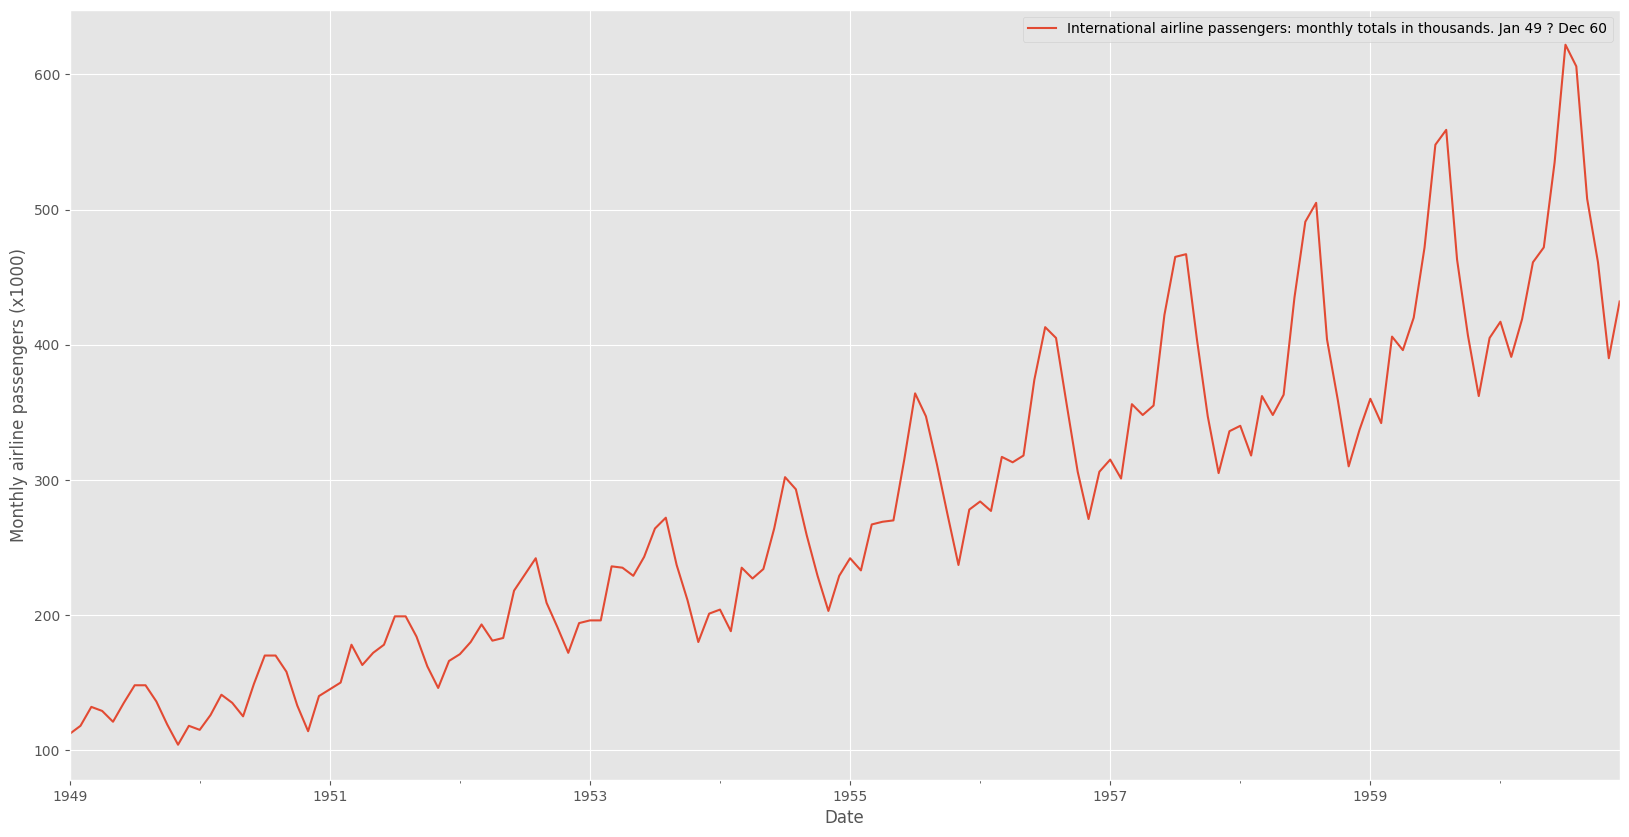

In [2]:
# Load the data
data = pd.read_csv('international-airline-passengers.csv', engine='python', skipfooter=3)
# A bit of pre-processing to make it nicer
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m')
data.set_index(['Month'], inplace=True)

# Plot the data
data.plot()
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.show()

Two En los datos aparecen dos patrones obvios: un aumento general del número de pasajeros a lo largo del tiempo y una estacionalidad de 12 meses con picos correspondientes al periodo estival del hemisferio norte.

#ARIMA 
significa Media Móvil Integrada Auto-Regresiva. Hay tres números enteros (p, d, q) que se utilizan para parametrizar modelos ARIMA. Por eso, un modelo ARIMA no estacional se denota con ARIMA(p, d, q):
<ul>
<li><strong>p</strong> es el número de términos autorregresivos (parte AR). Permite incorporar el efecto de valores pasados ​​a nuestro modelo. Intuitivamente, esto sería similar a afirmar que es probable que haga calor mañana si ha estado caliente los últimos 3 días.</li>
<li><strong>d</strong> es el número de diferencias no estacionales necesarias para la estacionariedad. Intuitivamente, esto sería similar a afirmar que es probable que mañana haya la misma temperatura si la diferencia de temperatura en los últimos tres días ha sido muy pequeña.</li>
<li><strong>q</strong> es el número de errores de pronóstico retrasados ​​en la ecuación de predicción (parte MA). Esto nos permite establecer el error de nuestro modelo como una combinación lineal de los valores de error observados en puntos de tiempo anteriores en el pasado.</li>
</ul>

Cuando se trata de efectos estacionales, como en nuestro ejemplo, se utiliza ARIMA estacional, que se denota como ARIMA(p,d,q)(P,D,Q)s. Aquí, (p, d, q) son los parámetros no estacionales descritos anteriormente, (<strong>P, D, Q</strong>) siguen la misma definición pero se aplican al componente estacional de la serie temporal. El término <strong>s</strong> es la periodicidad de la serie temporal.

Aunque en este caso está claro que s=12, ¿cómo fijamos los demás parámetros?

Se basa bastante en la experiencia. Existen numerosas prácticas recomendadas que pueden seguirse para identificar los modelos ARIMA, como por ejemplo
http://people.duke.edu/~rnau/arimrule.htm.

Aquí utilizamos la búsqueda de cuadrícula sobre todas las combinaciones posibles de valores de parámetros dentro de un rango predefinido de valores (muy inspirado en https://www.digitalocean.com/community/tutorials/a-guide-to-time-series- pronóstico-con-arima-en-python-3).

$statsmodels.tsa.statespace.sarimax.SARIMAXResults$ devuelve valores de AIC (Criterio de Información de Akaike) y BIC (Criterio de Información de Bayes) que pueden minimizarse para seleccionar el modelo que mejor se ajuste. Utilizamos el valor AIC, que estima la información perdida cuando se utiliza un modelo determinado para representar el proceso que genera los datos. Al hacerlo, se ocupa del compromiso entre la bondad del ajuste del modelo y la complejidad del propio modelo.



In [3]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We select a subset of the data series as training data, say the first 11 years. Our goal is to predict the last year of the series based on this input.

In [4]:
train_data = data['1949-01-01':'1959-12-01']
test_data = data['1960-01-01':'1960-12-01']

In [5]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (3, 0, 0, 12),
 (3, 0, 1, 12),
 (3, 1, 0, 12),
 (3, 1, 1, 12)]

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [13]:
AIC = [629]
SARIMAX_model = [(3, 0, 1),(3, 1, 0, 12)]

In [14]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 629 for model SARIMAX3x0


In [22]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=(3, 0, 1),#SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=(3, 1, 0,12),#SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

H:\Anaconda\envs\IA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
H:\Anaconda\envs\IA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Una vez que el modelo ha sido ajustado, podemos verificar si hace lo que esperábamos y si se violan las suposiciones que hicimos. Para hacer esto, podemos usar el método $plot\_diagnostics$.

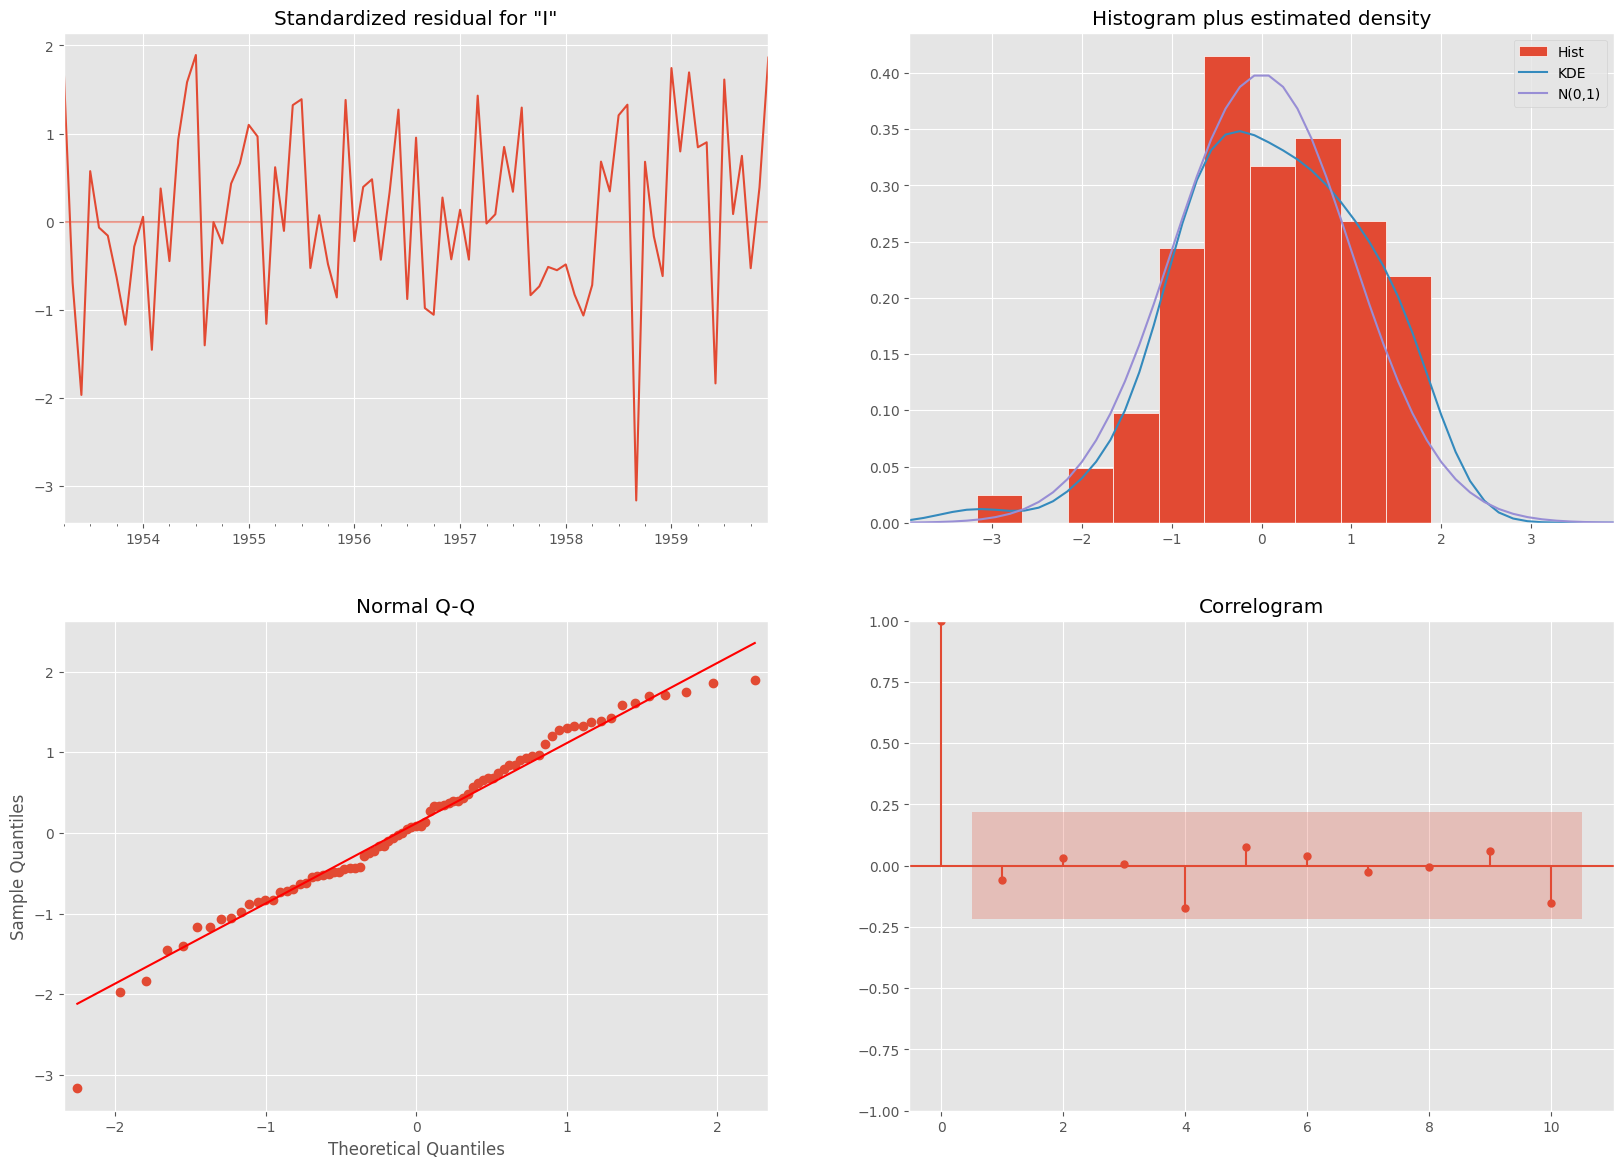

In [23]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

En los gráficos anteriores, podemos observar que los residuos no están correlacionados (gráfico inferior derecho) y no muestran ninguna estacionalidad obvia (gráfico superior izquierdo). Además, los residuos y aproximadamente normalmente distribuidos con media cero (gráfico superior derecho). El diagrama qq en la parte inferior izquierda muestra que la distribución ordenada de residuos (puntos azules) sigue aproximadamente la tendencia lineal de las muestras tomadas de una distribución normal estándar con N (0, 1). Nuevamente, esta es una fuerte indicación de que los residuos se distribuyen normalmente.

Resultados

1) En predicción de muestra con pronóstico de 1 paso adelante del último año (1959). En este caso, el modelo se usa para predecir los datos sobre los que se construyó el modelo. El pronóstico de 1 paso adelante implica que cada punto pronosticado se usa para predecir el siguiente.

In [24]:
pred0 = results.get_prediction(start='1958-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

2) En predicción muestral con predicción dinámica del último año (1959). Una vez más, el modelo se utiliza para predecir los datos sobre los que se construyó el modelo.

In [25]:
pred1 = results.get_prediction(start='1958-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

Cuando establece dynamic=True, el modelo predice continuamente un paso adelante (t+1) y luego, para la predicción del segundo paso adelante (t+2), agrega el valor predicho (t+1) a los datos, vuelve a ajustar el modelo a partir de los nuevos datos ampliados, se realiza un pronóstico de 2.º paso adelante. Esto se llama predicción fuera de la muestra.

Cuando establece dinámico = Falso, el modelo predice secuencialmente un paso adelante usando el valor verdadero del paso de tiempo anterior en lugar de usar el valor predicho. Esto se llama predicción en la muestra.

3) Pronóstico "verdadero" de datos fuera de muestra. En este caso, se le pide al modelo que prediga datos que no ha visto antes.

In [26]:
pred2 = results.get_forecast('1962-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['1960-01-01':'1960-12-01'])

1960-01-01    423.123169
1960-02-01    403.121885
1960-03-01    465.412355
1960-04-01    452.734318
1960-05-01    476.212489
1960-06-01    528.130519
1960-07-01    604.638193
1960-08-01    616.503484
1960-09-01    513.335584
1960-10-01    456.346339
1960-11-01    408.457323
1960-12-01    449.380689
Freq: MS, Name: predicted_mean, dtype: float64


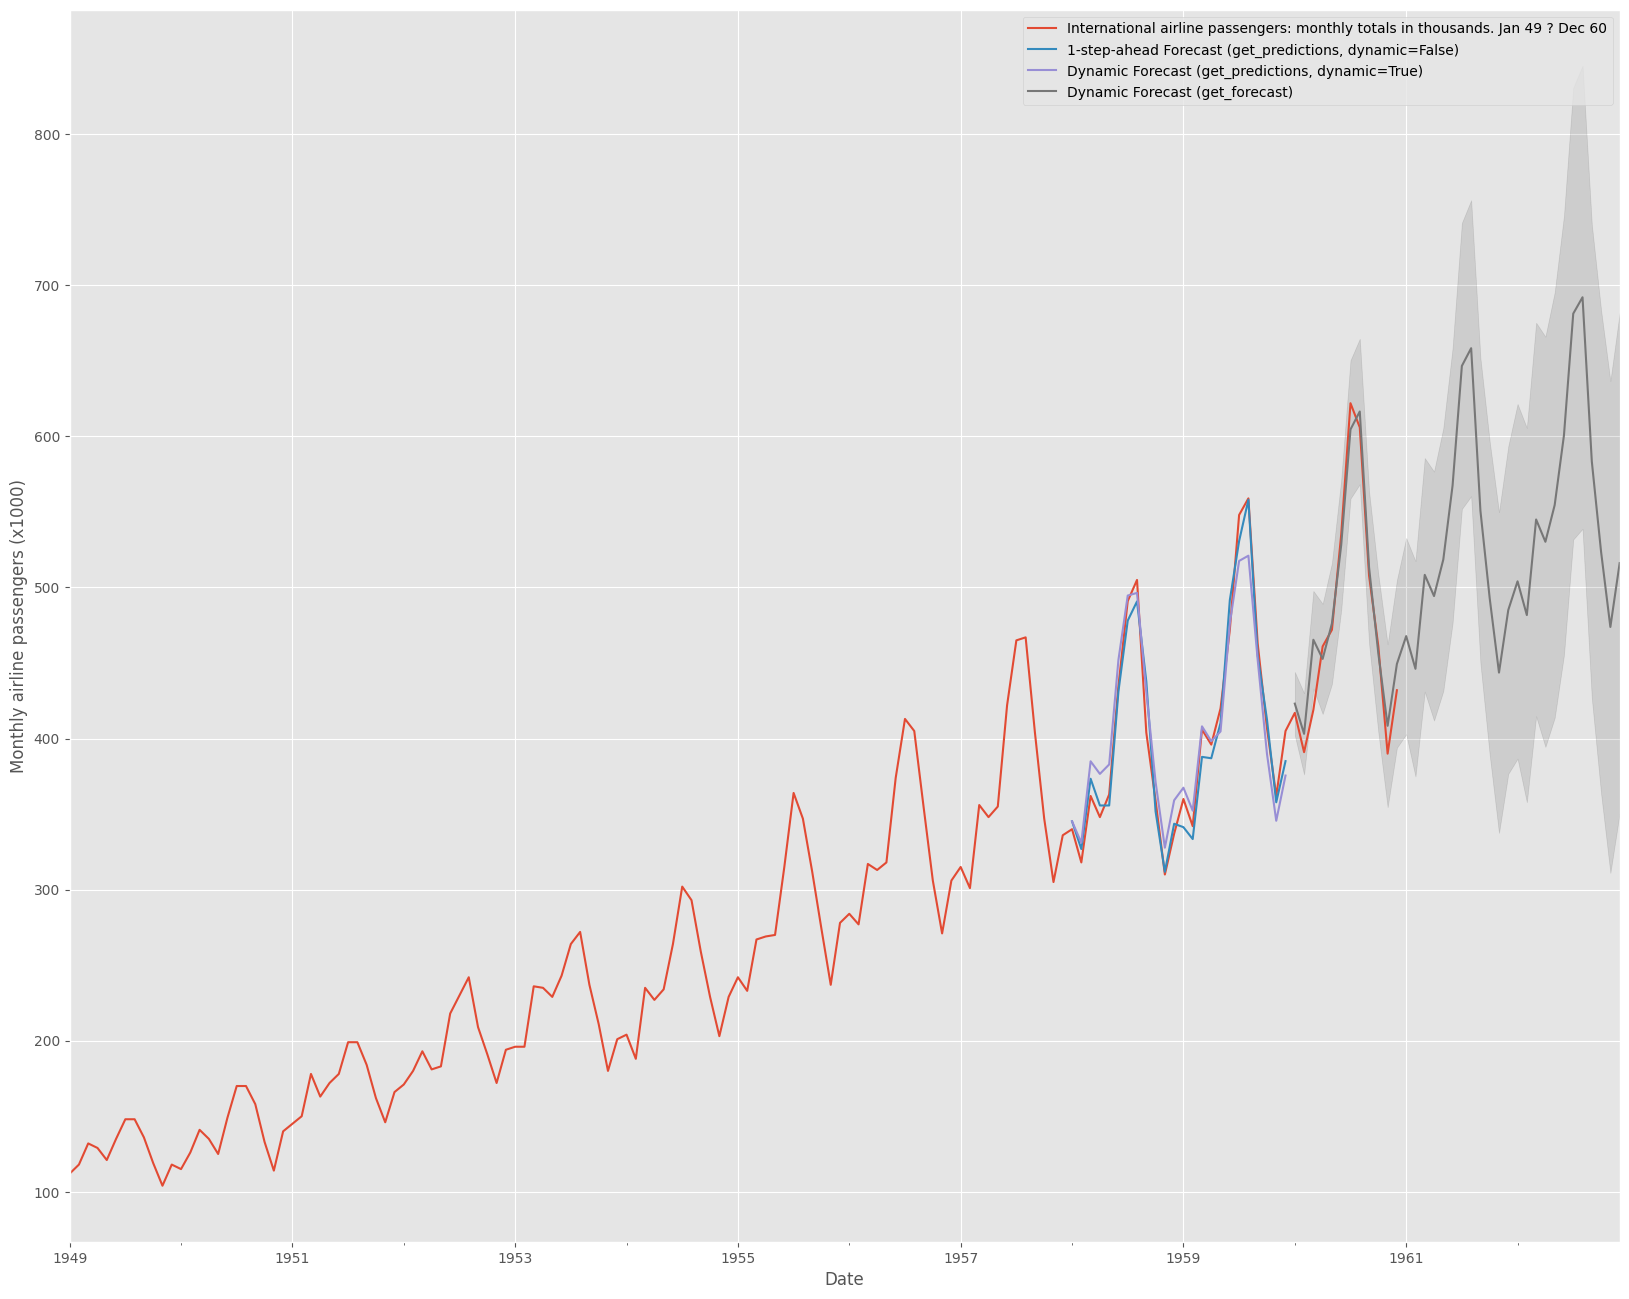

In [27]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

Mirando la figura, el modelo parece hacer un buen trabajo al modelar la serie de tiempo. Las líneas azul y púrpura están, como era de esperar, muy cerca de la verdad del fondo rojo. Lo que es más interesante es la línea gris, la predicción fuera de muestra. Para una serie de tiempo tan simple, el modelo ARIMA puede pronosticar los valores de 1960 con precisión.

Para cuantificar la precisión de la predicción para 1960, podemos calcular métricas como el error absoluto medio, el error cuadrático medio o el error cuadrático medio. Todas estas son métricas absolutas, por lo tanto, dependen de la escala. Si bien son útiles y se usan ampliamente para comparar diferentes métodos en un mismo conjunto de datos, aquí sería más útil expresar el error en relación con la magnitud de la serie temporal que estamos tratando de predecir. Una medida de error porcentual comúnmente utilizada es el error porcentual absoluto medio (MAPE). Tiene algunos inconvenientes en casos especiales (en particular, puede llevar a la división por cero) y se han propuesto medidas mejoradas, véase, p. https://www.otexts.org/fpp/2/5 para obtener una buena descripción general. Sin embargo, para este ejemplo nos quedaremos con MAPE.

In [ ]:
prediction = pred2.predicted_mean['1960-01-01':'1960-12-01'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 1960 is {:.2f}%'.format(MAPE))